##code_without_execution_time

Using device: cuda

Dataset Information:
  Training samples: 60000
  Test samples: 10000
  Calculated batch size: 600 (to achieve 100 iterations/epoch)

Training Configuration:
  Iterations per epoch: 100
  Number of epochs: 50
  Total iterations: 5000

Training Vision Transformer
Epoch 1/50:
  Train Loss: 1.8641
  Train Accuracy (overall): 60.80%
  Average Accuracy per Iteration: 60.80%
  Test Accuracy: 79.09%
  Iterations: 100
Epoch 2/50:
  Train Loss: 1.6575
  Train Accuracy (overall): 80.53%
  Average Accuracy per Iteration: 80.53%
  Test Accuracy: 81.57%
  Iterations: 100
Epoch 3/50:
  Train Loss: 1.6361
  Train Accuracy (overall): 82.60%
  Average Accuracy per Iteration: 82.60%
  Test Accuracy: 83.13%
  Iterations: 100
Epoch 4/50:
  Train Loss: 1.6200
  Train Accuracy (overall): 84.19%
  Average Accuracy per Iteration: 84.19%
  Test Accuracy: 90.71%
  Iterations: 100
Epoch 5/50:
  Train Loss: 1.5542
  Train Accuracy (overall): 90.84%
  Average Accuracy per Iteration: 90.84%
  Tes

/tmp/ipython-input-775625551.py:334: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


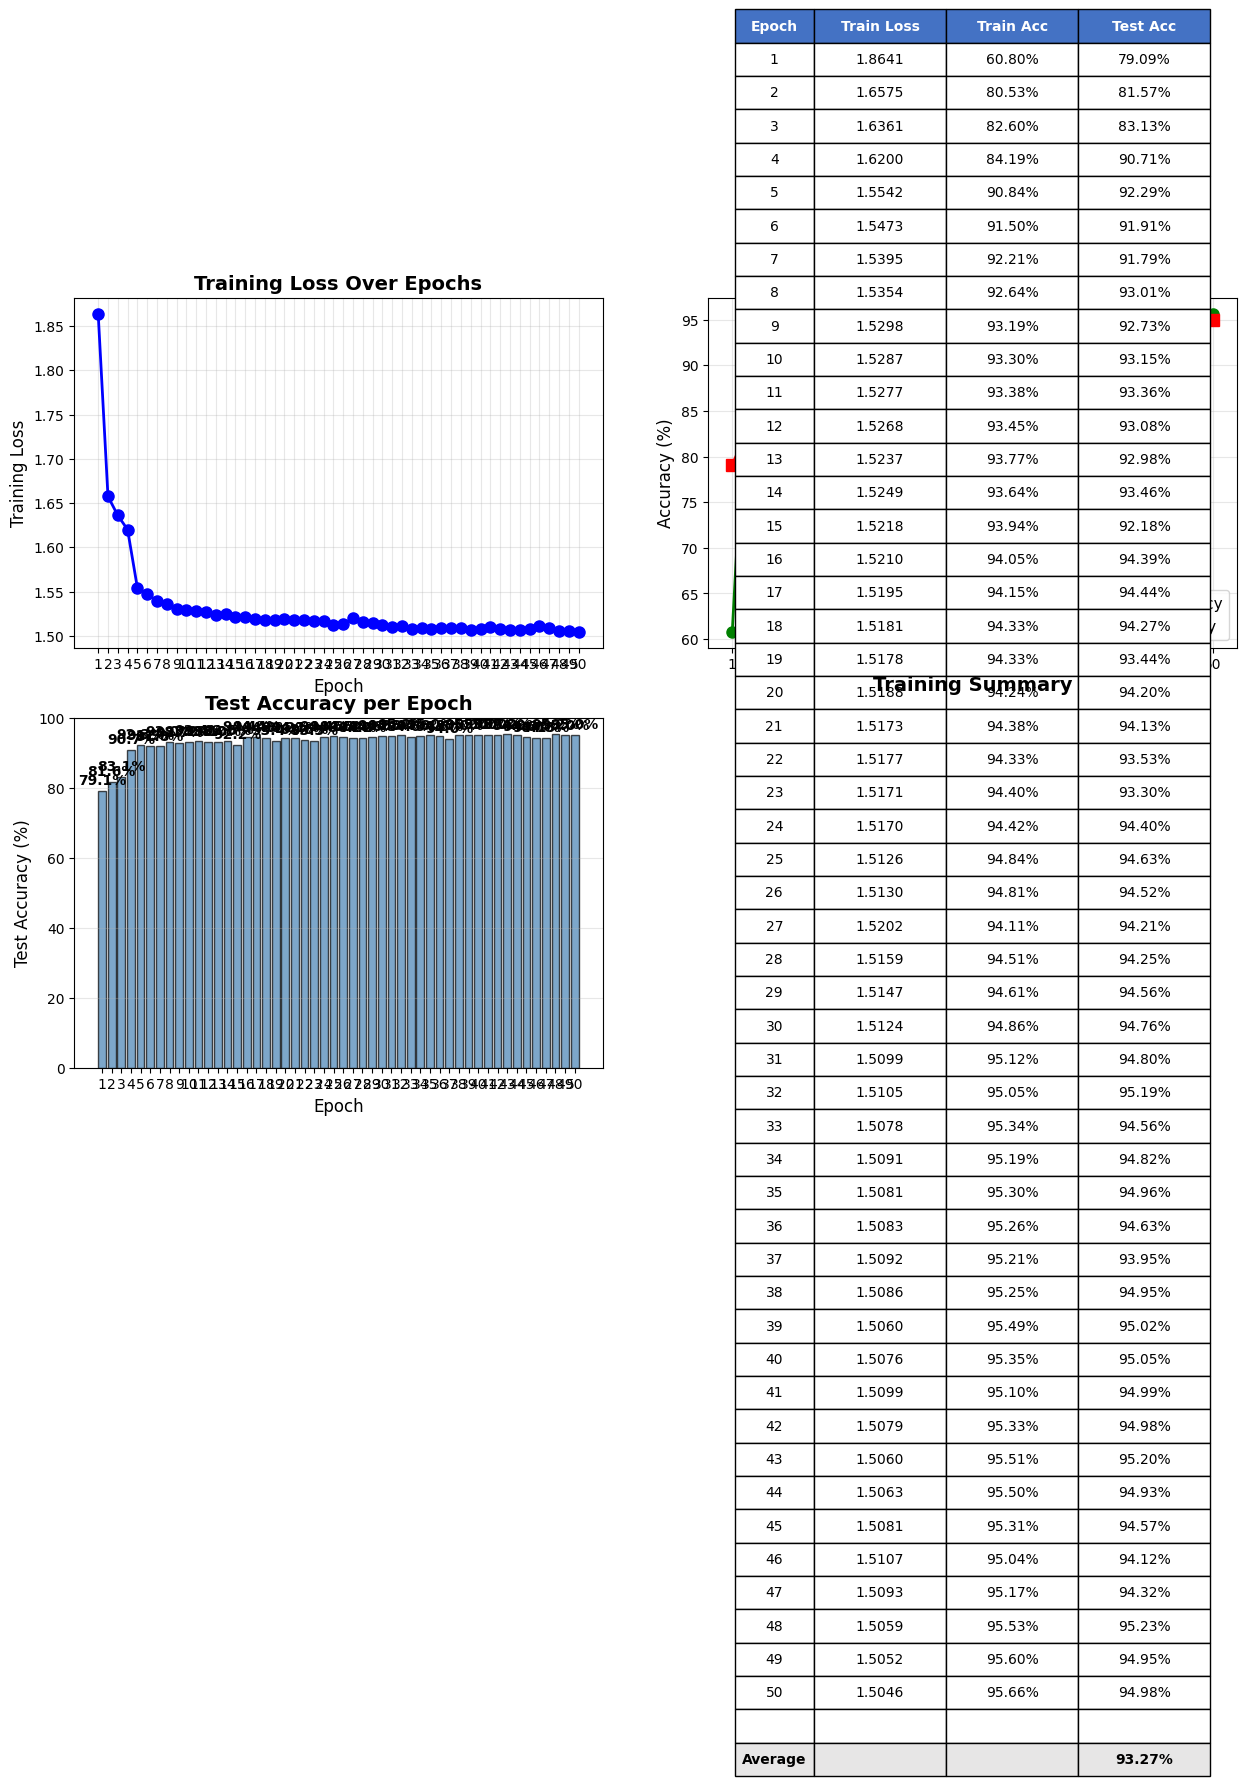


Plot saved as 'vit_training_results.png'


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
d_model = 9
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 3
n_layers = 3
n_iterations_per_epoch = 100  # 100 iterations per epoch
epochs = 50
alpha = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.linear_project = nn.Conv2d(self.n_channels, self.d_model,
                                       kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
                else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        x = x + self.pe
        return x

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention = Q @ K.transpose(-2, -1)
        attention = attention / (self.head_size ** 0.5)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ V
        return attention

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.head_size = d_model // n_heads
        self.W_o = nn.Linear(d_model, d_model)
        self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.W_o(out)
        return out

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.mlp(self.ln2(out))
        return out

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

# Data loading
transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor()
])

# Load datasets first
train_set = MNIST(root='/content/train', train=True, download=True, transform=transform)
test_set = MNIST(root='/content/test', train=False, download=True, transform=transform)

# Calculate batch size dynamically based on dataset size
train_dataset_size = len(train_set)
batch_size = train_dataset_size // n_iterations_per_epoch

print(f"\nDataset Information:")
print(f"  Training samples: {train_dataset_size}")
print(f"  Test samples: {len(test_set)}")
print(f"  Calculated batch size: {batch_size} (to achieve {n_iterations_per_epoch} iterations/epoch)")

# Create data loaders with calculated batch size
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

print(f"\nTraining Configuration:")
print(f"  Iterations per epoch: {len(train_loader)}")
print(f"  Number of epochs: {epochs}")
print(f"  Total iterations: {len(train_loader) * epochs}")

# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Initialize model
print(f"\n{'='*60}")
print("Training Vision Transformer")
print(f"{'='*60}")

transformer = VisionTransformer(d_model, n_classes, img_size, patch_size,
                               n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []

# Train for 5 epochs
for epoch in range(epochs):
    transformer.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    # Track accuracy per iteration within the epoch
    iteration_accuracies = []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Calculate accuracy for this batch/iteration
        batch_correct = (predicted == labels).sum().item()
        batch_accuracy = 100 * batch_correct / labels.size(0)
        iteration_accuracies.append(batch_accuracy)

    # Calculate epoch metrics
    avg_train_loss = training_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    test_accuracy = evaluate(transformer, test_loader, device)
    avg_iteration_accuracy = np.mean(iteration_accuracies)  # Average accuracy per iteration in this epoch

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Train Accuracy (overall): {train_accuracy:.2f}%")
    print(f"  Average Accuracy per Iteration: {avg_iteration_accuracy:.2f}%")
    print(f"  Test Accuracy: {test_accuracy:.2f}%")
    print(f"  Iterations: {len(train_loader)}")

# Calculate average test accuracy across all epochs
avg_test_accuracy = np.mean(epoch_test_accuracies)

print(f"\n{'='*60}")
print("Training Complete!")
print(f"{'='*60}")
print(f"Average Test Accuracy (across {epochs} epochs): {avg_test_accuracy:.2f}%")
print(f"Final Test Accuracy (epoch {epochs}): {epoch_test_accuracies[-1]:.2f}%")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, epochs + 1)

# Plot 1: Training Loss
axes[0, 0].plot(epochs_range, epoch_train_losses, marker='o', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(epochs_range)

# Plot 2: Train vs Test Accuracy
axes[0, 1].plot(epochs_range, epoch_train_accuracies, marker='o', linewidth=2, markersize=8,
                color='green', label='Train Accuracy')
axes[0, 1].plot(epochs_range, epoch_test_accuracies, marker='s', linewidth=2, markersize=8,
                color='red', label='Test Accuracy')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(epochs_range)

# Plot 3: Test Accuracy per Epoch (Bar chart)
bars = axes[1, 0].bar(epochs_range, epoch_test_accuracies, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Test Accuracy per Epoch', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(epochs_range)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, epoch_test_accuracies)):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Summary Table
axes[1, 1].axis('off')
summary_data = [
    ['Epoch', 'Train Loss', 'Train Acc', 'Test Acc'],
    *[[f'{i+1}', f'{epoch_train_losses[i]:.4f}',
       f'{epoch_train_accuracies[i]:.2f}%', f'{epoch_test_accuracies[i]:.2f}%']
      for i in range(epochs)],
    ['', '', '', ''],
    ['Average', '', '', f'{avg_test_accuracy:.2f}%']
]

table = axes[1, 1].table(cellText=summary_data, cellLoc='center', loc='center',
                         colWidths=[0.15, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style average row
for i in range(4):
    table[(epochs + 2, i)].set_facecolor('#E7E6E6')
    table[(epochs + 2, i)].set_text_props(weight='bold')

axes[1, 1].set_title('Training Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('vit_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'vit_training_results.png'")

##code_with_execution_time

Using device: cuda

Loading Data...

Dataset Information:
  Training samples: 60000
  Test samples: 10000
  Calculated batch size: 600 (to achieve 100 iterations/epoch)
  Data loading time: 0.08 seconds

Training Configuration:
  Iterations per epoch: 100
  Number of epochs: 50
  Total iterations: 5000

Training Vision Transformer
Model initialization time: 0.01 seconds

Epoch 1/50:
  Train Loss: 1.9575
  Train Accuracy (overall): 51.30%
  Average Accuracy per Iteration: 51.30%
  Test Accuracy: 70.20%
  Iterations: 100
  Epoch Time: 11.83 seconds

Epoch 2/50:
  Train Loss: 1.7406
  Train Accuracy (overall): 72.21%
  Average Accuracy per Iteration: 72.21%
  Test Accuracy: 74.57%
  Iterations: 100
  Epoch Time: 11.85 seconds

Epoch 3/50:
  Train Loss: 1.6717
  Train Accuracy (overall): 79.16%
  Average Accuracy per Iteration: 79.16%
  Test Accuracy: 82.01%
  Iterations: 100
  Epoch Time: 11.86 seconds

Epoch 4/50:
  Train Loss: 1.6400
  Train Accuracy (overall): 82.16%
  Average Accuracy

/tmp/ipython-input-2943543604.py:381: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


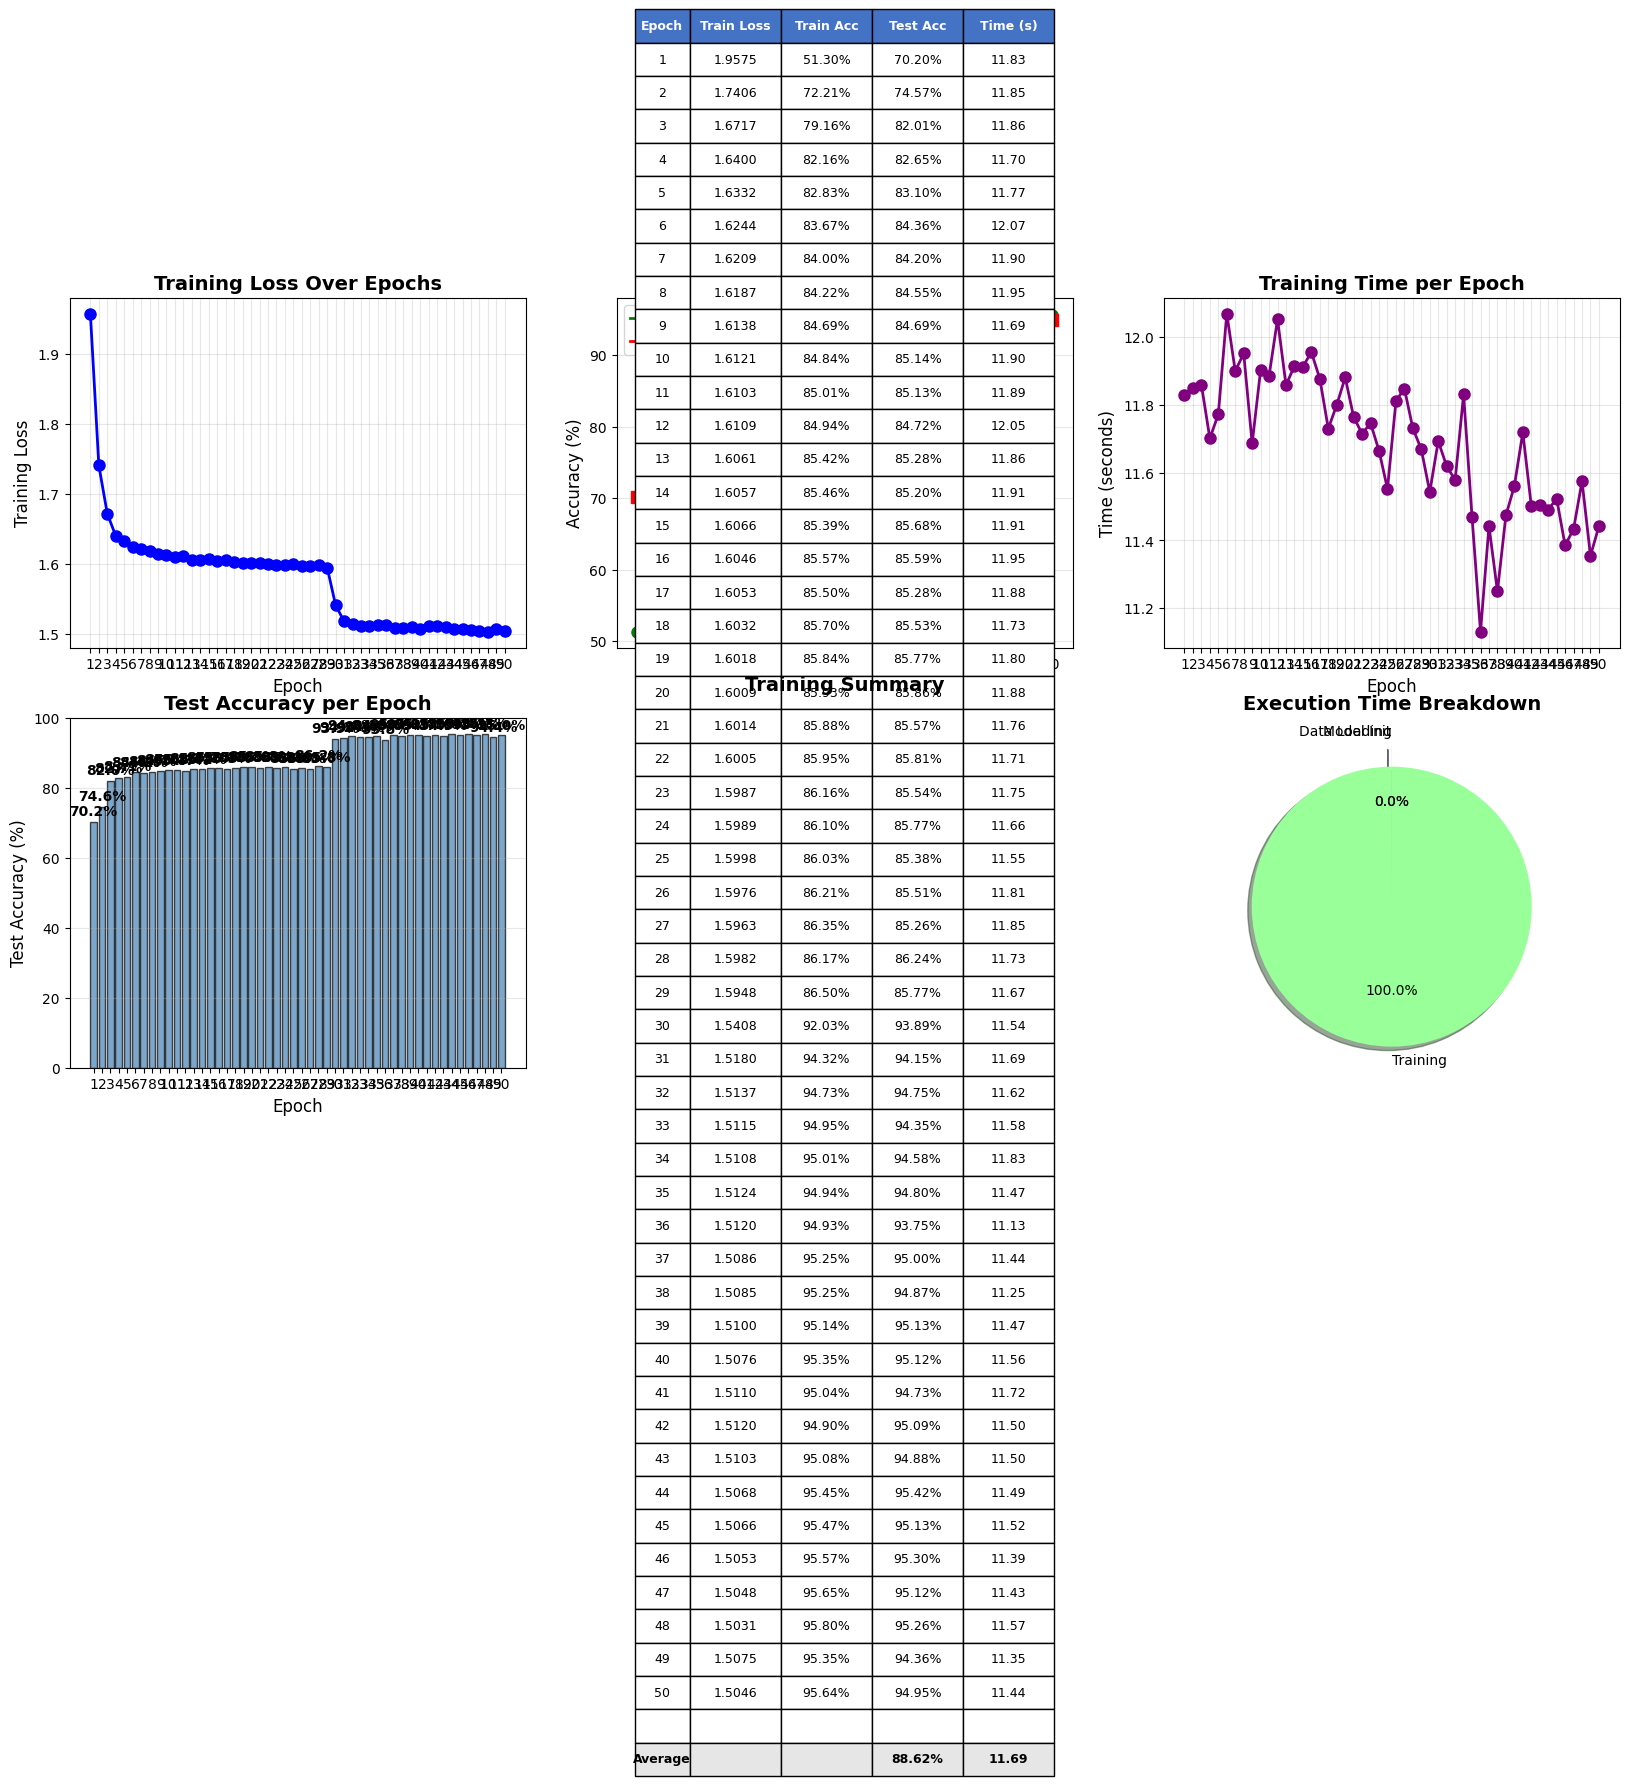


Plot saved as 'vit_training_results.png'


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

# Hyperparameters
d_model = 9
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 3
n_layers = 3
n_iterations_per_epoch = 100
epochs = 50   # no of epoch
alpha = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.linear_project = nn.Conv2d(self.n_channels, self.d_model,
                                       kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
                else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        x = x + self.pe
        return x

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention = Q @ K.transpose(-2, -1)
        attention = attention / (self.head_size ** 0.5)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ V
        return attention

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.head_size = d_model // n_heads
        self.W_o = nn.Linear(d_model, d_model)
        self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.W_o(out)
        return out

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.mlp(self.ln2(out))
        return out

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

# Start overall timer
overall_start_time = time.time()

# Data loading
print("\n" + "="*60)
print("Loading Data...")
print("="*60)
data_load_start = time.time()

transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor()
])

train_set = MNIST(root='/content/train', train=True, download=True, transform=transform)
test_set = MNIST(root='/content/test', train=False, download=True, transform=transform)

train_dataset_size = len(train_set)
batch_size = train_dataset_size // n_iterations_per_epoch

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

data_load_time = time.time() - data_load_start

print(f"\nDataset Information:")
print(f"  Training samples: {train_dataset_size}")
print(f"  Test samples: {len(test_set)}")
print(f"  Calculated batch size: {batch_size} (to achieve {n_iterations_per_epoch} iterations/epoch)")
print(f"  Data loading time: {data_load_time:.2f} seconds")

print(f"\nTraining Configuration:")
print(f"  Iterations per epoch: {len(train_loader)}")
print(f"  Number of epochs: {epochs}")
print(f"  Total iterations: {len(train_loader) * epochs}")

# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Initialize model
print(f"\n{'='*60}")
print("Training Vision Transformer")
print(f"{'='*60}")

model_init_start = time.time()
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size,
                               n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()
model_init_time = time.time() - model_init_start
print(f"Model initialization time: {model_init_time:.2f} seconds")

epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []
epoch_times = []

# Train for 5 epochs
training_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    transformer.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    iteration_accuracies = []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        batch_correct = (predicted == labels).sum().item()
        batch_accuracy = 100 * batch_correct / labels.size(0)
        iteration_accuracies.append(batch_accuracy)

    # Calculate epoch metrics
    avg_train_loss = training_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    test_accuracy = evaluate(transformer, test_loader, device)
    avg_iteration_accuracy = np.mean(iteration_accuracies)
    epoch_time = time.time() - epoch_start_time

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_test_accuracies.append(test_accuracy)
    epoch_times.append(epoch_time)

    print(f"\nEpoch {epoch + 1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Train Accuracy (overall): {train_accuracy:.2f}%")
    print(f"  Average Accuracy per Iteration: {avg_iteration_accuracy:.2f}%")
    print(f"  Test Accuracy: {test_accuracy:.2f}%")
    print(f"  Iterations: {len(train_loader)}")
    print(f"  Epoch Time: {epoch_time:.2f} seconds")

total_training_time = time.time() - training_start_time
total_execution_time = time.time() - overall_start_time

# Calculate average test accuracy across all epochs
avg_test_accuracy = np.mean(epoch_test_accuracies)
avg_epoch_time = np.mean(epoch_times)

print(f"\n{'='*60}")
print("Training Complete!")
print(f"{'='*60}")
print(f"Average Test Accuracy (across {epochs} epochs): {avg_test_accuracy:.2f}%")
print(f"Final Test Accuracy (epoch {epochs}): {epoch_test_accuracies[-1]:.2f}%")
print(f"\n{'='*60}")
print("Execution Time Summary")
print(f"{'='*60}")
print(f"Data Loading Time: {data_load_time:.2f} seconds")
print(f"Model Initialization Time: {model_init_time:.2f} seconds")
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")
print(f"Total Execution Time: {total_execution_time:.2f} seconds ({total_execution_time/60:.2f} minutes)")

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

epochs_range = range(1, epochs + 1)

# Plot 1: Training Loss
axes[0, 0].plot(epochs_range, epoch_train_losses, marker='o', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(epochs_range)

# Plot 2: Train vs Test Accuracy
axes[0, 1].plot(epochs_range, epoch_train_accuracies, marker='o', linewidth=2, markersize=8,
                color='green', label='Train Accuracy')
axes[0, 1].plot(epochs_range, epoch_test_accuracies, marker='s', linewidth=2, markersize=8,
                color='red', label='Test Accuracy')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(epochs_range)

# Plot 3: Epoch Time
axes[0, 2].plot(epochs_range, epoch_times, marker='o', linewidth=2, markersize=8, color='purple')
axes[0, 2].set_xlabel('Epoch', fontsize=12)
axes[0, 2].set_ylabel('Time (seconds)', fontsize=12)
axes[0, 2].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(epochs_range)

# Plot 4: Test Accuracy per Epoch (Bar chart)
bars = axes[1, 0].bar(epochs_range, epoch_test_accuracies, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Test Accuracy per Epoch', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(epochs_range)

for i, (bar, val) in enumerate(zip(bars, epoch_test_accuracies)):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 5: Summary Table
axes[1, 1].axis('off')
summary_data = [
    ['Epoch', 'Train Loss', 'Train Acc', 'Test Acc', 'Time (s)'],
    *[[f'{i+1}', f'{epoch_train_losses[i]:.4f}',
       f'{epoch_train_accuracies[i]:.2f}%', f'{epoch_test_accuracies[i]:.2f}%',
       f'{epoch_times[i]:.2f}']
      for i in range(epochs)],
    ['', '', '', '', ''],
    ['Average', '', '', f'{avg_test_accuracy:.2f}%', f'{avg_epoch_time:.2f}']
]

table = axes[1, 1].table(cellText=summary_data, cellLoc='center', loc='center',
                         colWidths=[0.12, 0.20, 0.20, 0.20, 0.20])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(5):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(5):
    table[(epochs + 2, i)].set_facecolor('#E7E6E6')
    table[(epochs + 2, i)].set_text_props(weight='bold')

axes[1, 1].set_title('Training Summary', fontsize=14, fontweight='bold', pad=20)

# Plot 6: Execution Time Breakdown (Pie chart)
time_breakdown = {
    'Data Loading': data_load_time,
    'Model Init': model_init_time,
    'Training': total_training_time
}
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.05, 0.05, 0.1)

axes[1, 2].pie(time_breakdown.values(), labels=time_breakdown.keys(), autopct='%1.1f%%',
               startangle=90, colors=colors, explode=explode, shadow=True)
axes[1, 2].set_title('Execution Time Breakdown', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('vit_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'vit_training_results.png'")

#porishkar graph

Using device: cuda

Loading Data...

Dataset Information:
  Training samples: 60000
  Test samples: 10000
  Calculated batch size: 600 (to achieve 100 iterations/epoch)
  Data loading time: 0.09 seconds

Training Configuration:
  Iterations per epoch: 100
  Number of epochs: 50
  Total iterations: 5000

Training Vision Transformer
Model initialization time: 0.02 seconds
Epoch 10/50: Train Loss: 1.6087, Train Acc: 85.20%, Test Acc: 85.46%
Epoch 20/50: Train Loss: 1.5960, Train Acc: 86.46%, Test Acc: 86.35%
Epoch 30/50: Train Loss: 1.5158, Train Acc: 94.53%, Test Acc: 94.13%
Epoch 40/50: Train Loss: 1.5129, Train Acc: 94.83%, Test Acc: 94.58%
Epoch 50/50: Train Loss: 1.5025, Train Acc: 95.85%, Test Acc: 95.44%

Training Complete!
Average Train Accuracy: 89.36%
Average Test Accuracy: 89.68%
Final Test Accuracy: 95.44%

Execution Time Summary:
  Data Loading Time: 0.09 seconds
  Model Initialization Time: 0.02 seconds
  Total Training Time: 565.87 seconds
  Average Time per Epoch: 11.32 se

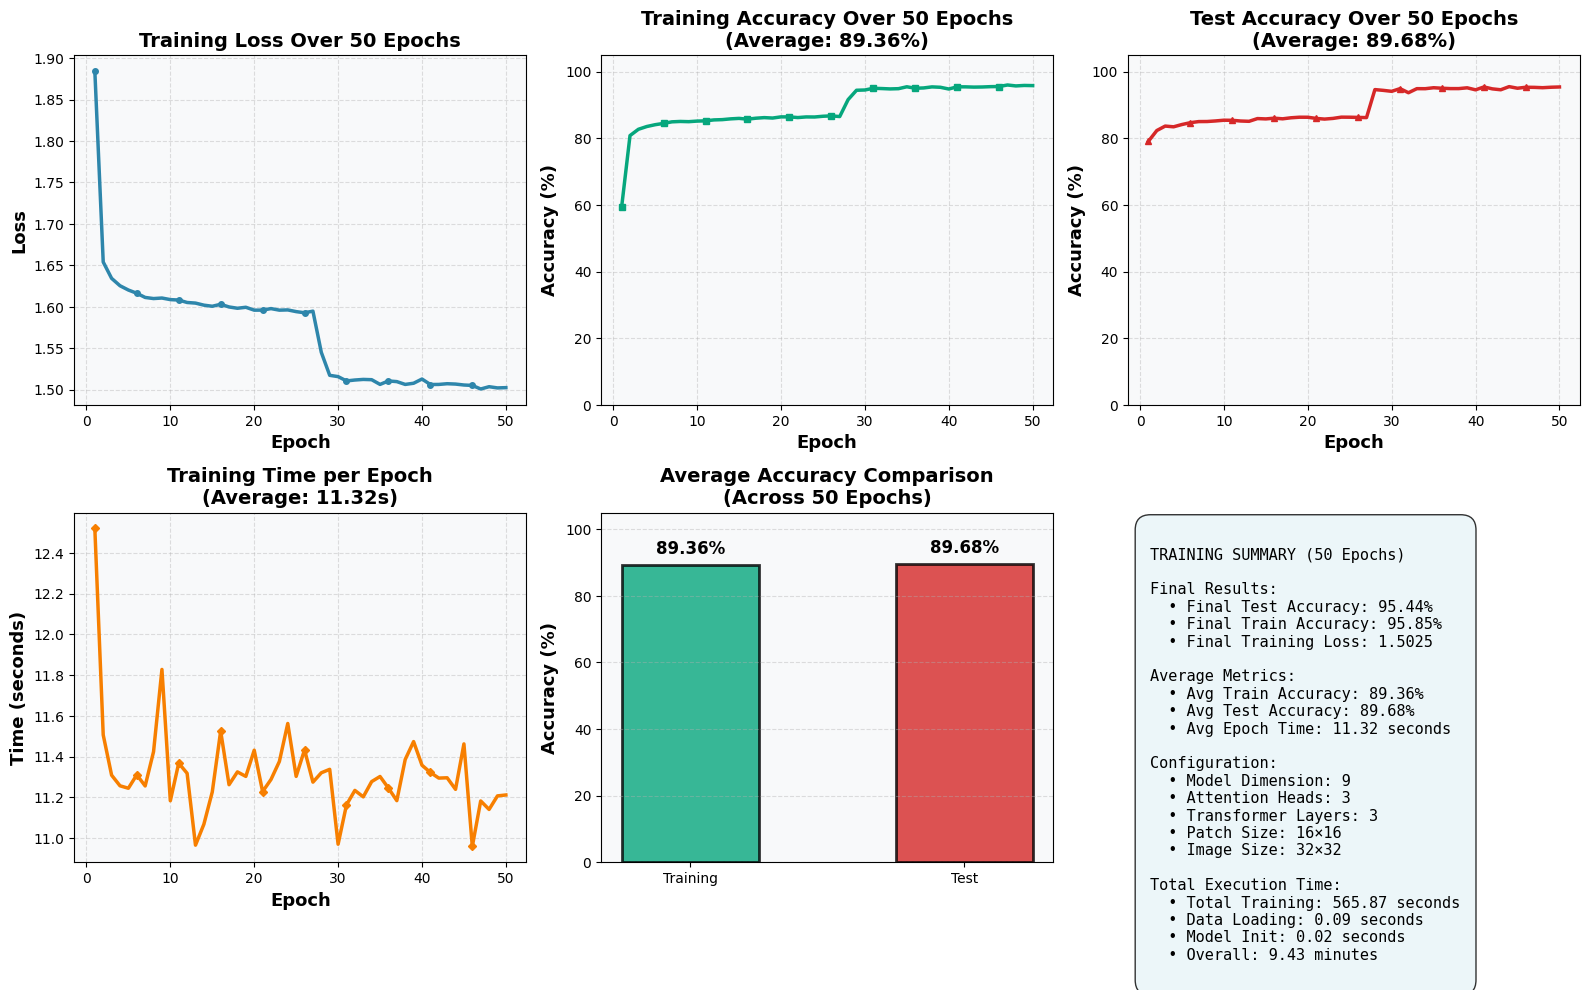


Plot saved as 'vit_training_results_clear.png'


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

# Hyperparameters
d_model = 9
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 3
n_layers = 3
n_iterations_per_epoch = 100
epochs = 50
alpha = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.linear_project = nn.Conv2d(self.n_channels, self.d_model,
                                       kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
                else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        x = x + self.pe
        return x

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention = Q @ K.transpose(-2, -1)
        attention = attention / (self.head_size ** 0.5)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ V
        return attention

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.head_size = d_model // n_heads
        self.W_o = nn.Linear(d_model, d_model)
        self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.W_o(out)
        return out

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.mlp(self.ln2(out))
        return out

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

# Start overall timer
overall_start_time = time.time()

# Data loading
print("\n" + "="*60)
print("Loading Data...")
print("="*60)
data_load_start = time.time()

transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor()
])

train_set = MNIST(root='/content/train', train=True, download=True, transform=transform)
test_set = MNIST(root='/content/test', train=False, download=True, transform=transform)

train_dataset_size = len(train_set)
batch_size = train_dataset_size // n_iterations_per_epoch

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

data_load_time = time.time() - data_load_start

print(f"\nDataset Information:")
print(f"  Training samples: {train_dataset_size}")
print(f"  Test samples: {len(test_set)}")
print(f"  Calculated batch size: {batch_size} (to achieve {n_iterations_per_epoch} iterations/epoch)")
print(f"  Data loading time: {data_load_time:.2f} seconds")

print(f"\nTraining Configuration:")
print(f"  Iterations per epoch: {len(train_loader)}")
print(f"  Number of epochs: {epochs}")
print(f"  Total iterations: {len(train_loader) * epochs}")

# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Initialize model
print(f"\n{'='*60}")
print("Training Vision Transformer")
print(f"{'='*60}")

model_init_start = time.time()
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size,
                               n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()
model_init_time = time.time() - model_init_start
print(f"Model initialization time: {model_init_time:.2f} seconds")

epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []
epoch_times = []

# Train for 50 epochs
training_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    transformer.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate epoch metrics
    avg_train_loss = training_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    test_accuracy = evaluate(transformer, test_loader, device)
    epoch_time = time.time() - epoch_start_time

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_test_accuracies.append(test_accuracy)
    epoch_times.append(epoch_time)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

total_training_time = time.time() - training_start_time
total_execution_time = time.time() - overall_start_time

# Calculate statistics
avg_test_accuracy = np.mean(epoch_test_accuracies)
avg_train_accuracy = np.mean(epoch_train_accuracies)
avg_epoch_time = np.mean(epoch_times)

print(f"\n{'='*60}")
print("Training Complete!")
print(f"{'='*60}")
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Accuracy: {avg_test_accuracy:.2f}%")
print(f"Final Test Accuracy: {epoch_test_accuracies[-1]:.2f}%")
print(f"\nExecution Time Summary:")
print(f"  Data Loading Time: {data_load_time:.2f} seconds")
print(f"  Model Initialization Time: {model_init_time:.2f} seconds")
print(f"  Total Training Time: {total_training_time:.2f} seconds")
print(f"  Average Time per Epoch: {avg_epoch_time:.2f} seconds")
print(f"  Total Execution Time: {total_execution_time:.2f} seconds ({total_execution_time/60:.2f} minutes)")

# Clear and simple plots
fig = plt.figure(figsize=(16, 10))

epochs_range = range(1, epochs + 1)

# Plot 1: Training Loss
ax1 = plt.subplot(2, 3, 1)
ax1.plot(epochs_range, epoch_train_losses, linewidth=2.5, color='#2E86AB', marker='o', markersize=4, markevery=5)
ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax1.set_title('Training Loss Over 50 Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_facecolor('#F8F9FA')

# Plot 2: Training Accuracy
ax2 = plt.subplot(2, 3, 2)
ax2.plot(epochs_range, epoch_train_accuracies, linewidth=2.5, color='#06A77D', marker='s', markersize=4, markevery=5)
ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax2.set_title(f'Training Accuracy Over 50 Epochs\n(Average: {avg_train_accuracy:.2f}%)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.set_facecolor('#F8F9FA')
ax2.set_ylim([0, 105])

# Plot 3: Test Accuracy
ax3 = plt.subplot(2, 3, 3)
ax3.plot(epochs_range, epoch_test_accuracies, linewidth=2.5, color='#D62828', marker='^', markersize=4, markevery=5)
ax3.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax3.set_title(f'Test Accuracy Over 50 Epochs\n(Average: {avg_test_accuracy:.2f}%)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.4, linestyle='--')
ax3.set_facecolor('#F8F9FA')
ax3.set_ylim([0, 105])

# Plot 4: Time per Epoch
ax4 = plt.subplot(2, 3, 4)
ax4.plot(epochs_range, epoch_times, linewidth=2.5, color='#F77F00', marker='D', markersize=4, markevery=5)
ax4.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax4.set_ylabel('Time (seconds)', fontsize=13, fontweight='bold')
ax4.set_title(f'Training Time per Epoch\n(Average: {avg_epoch_time:.2f}s)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.4, linestyle='--')
ax4.set_facecolor('#F8F9FA')

# Plot 5: Train vs Test Comparison (Averaged)
ax5 = plt.subplot(2, 3, 5)
categories = ['Training', 'Test']
averages = [avg_train_accuracy, avg_test_accuracy]
colors_bar = ['#06A77D', '#D62828']
bars = ax5.bar(categories, averages, width=0.5, color=colors_bar, edgecolor='black', linewidth=2, alpha=0.8)
ax5.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax5.set_title('Average Accuracy Comparison\n(Across 50 Epochs)', fontsize=14, fontweight='bold')
ax5.set_ylim([0, 105])
ax5.grid(True, alpha=0.4, axis='y', linestyle='--')
ax5.set_facecolor('#F8F9FA')

for bar, val in zip(bars, averages):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 6: Summary Statistics
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_text = f"""
TRAINING SUMMARY (50 Epochs)

Final Results:
  • Final Test Accuracy: {epoch_test_accuracies[-1]:.2f}%
  • Final Train Accuracy: {epoch_train_accuracies[-1]:.2f}%
  • Final Training Loss: {epoch_train_losses[-1]:.4f}

Average Metrics:
  • Avg Train Accuracy: {avg_train_accuracy:.2f}%
  • Avg Test Accuracy: {avg_test_accuracy:.2f}%
  • Avg Epoch Time: {avg_epoch_time:.2f} seconds

Configuration:
  • Model Dimension: {d_model}
  • Attention Heads: {n_heads}
  • Transformer Layers: {n_layers}
  • Patch Size: {patch_size[0]}×{patch_size[1]}
  • Image Size: {img_size[0]}×{img_size[1]}

Total Execution Time:
  • Total Training: {total_training_time:.2f} seconds
  • Data Loading: {data_load_time:.2f} seconds
  • Model Init: {model_init_time:.2f} seconds
  • Overall: {total_execution_time/60:.2f} minutes
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='#E8F4F8', alpha=0.8, pad=1))

plt.tight_layout()
plt.savefig('vit_training_results_clear.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nPlot saved as 'vit_training_results_clear.png'")